# Fair Price Estimation 

## Pricing of flow products
### The Kalman Filter model for pricing


T (timesteps): 1320
True Q:
 [[0.0005     0.00035777]
 [0.00035777 0.0004    ]]
Estimated Q:
 [[0.00026176 0.00011076]
 [0.00011076 0.00018142]]
True R diag: [0.001 0.002]
Estimated R diag: [0.00112302 0.00209805]
Final approx loglik: -3064.4240865168413
RMSE on second half: [0.04516242 0.04299883]


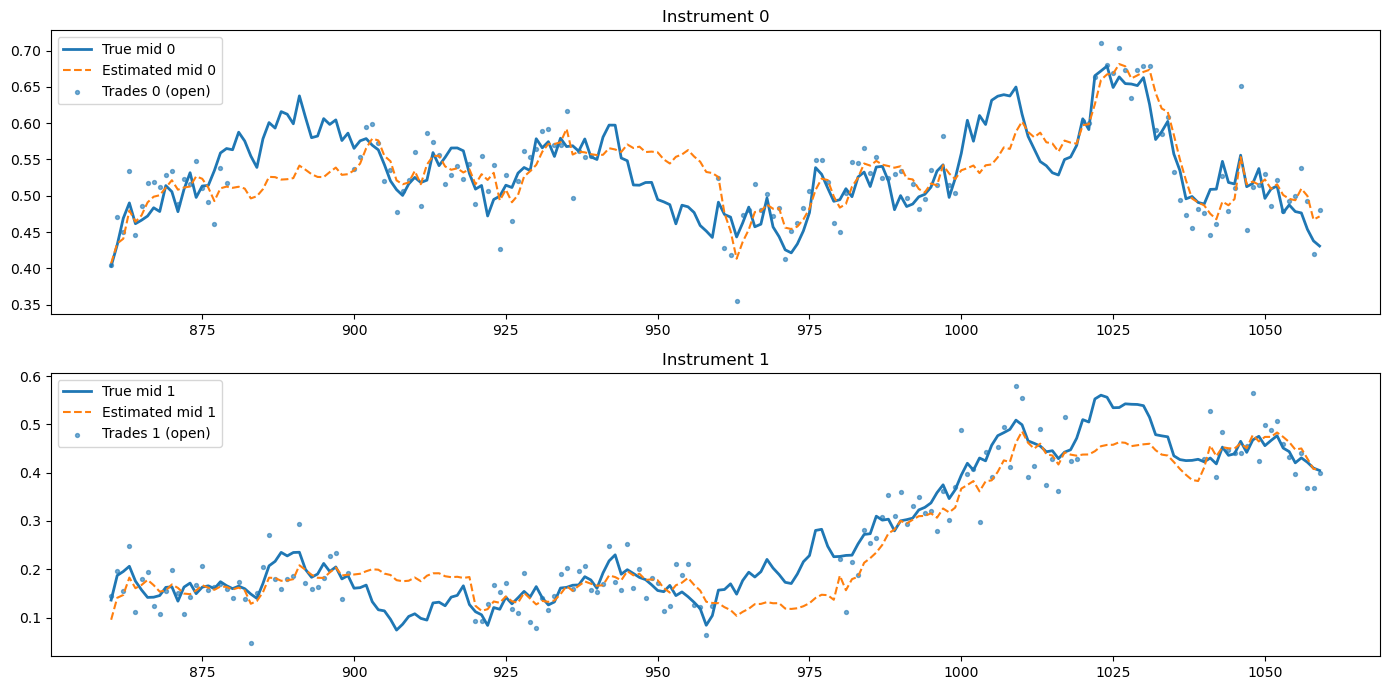

In [5]:
# Compromise execution: run full algorithm but with fewer timesteps/day so it completes here.
# Use 22 days × 60 steps/day = 1320 timesteps (faster but pattern preserved).
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

def make_obs_pattern(days=22, steps_per_day=60):
    pattern = []
    for _ in range(days):
        base = steps_per_day // 3
        rem = steps_per_day - 3 * base
        for _ in range(base): pattern.append(np.array([1, 0], dtype=bool))
        for _ in range(base): pattern.append(np.array([1, 1], dtype=bool))
        for _ in range(base + rem): pattern.append(np.array([0, 1], dtype=bool))
    return np.array(pattern)

def simulate_continuous_trades(Q, R, obs_pattern):
    # Q is the covariance matrix of the mid-price process
    # R is the covariance matrix of the observation process
    T = len(obs_pattern); n = Q.shape[0]
    mids = np.zeros((T, n)); trades = np.zeros((T,n))
    for t in range(1, T):
        mids[t] = mids[t-1] + np.random.multivariate_normal(np.zeros(n), Q)
    for t in range(T):
        trades[t] = mids[t] + np.random.multivariate_normal(np.zeros(n), R)
    return mids, trades

def kalman_filter_timevarying(y, R_time, A, Q, x0=None, P0=None):
    T = y.shape[0]; n = A.shape[0]
    xs = np.zeros((T, n)); Ps = np.zeros((T, n, n))
    if x0 is None: x0 = np.zeros(n)
    if P0 is None: P0 = np.eye(n)
    x_pred = x0.copy(); P_pred = P0.copy()
    for t in range(T):
        R_t = R_time[t]
        S = P_pred + R_t + np.eye(n)*1e-12
        K = P_pred @ np.linalg.inv(S)
        innov = y[t] - x_pred
        x_upd = x_pred + K @ innov
        P_upd = (np.eye(n) - K) @ P_pred
        xs[t] = x_upd; Ps[t] = P_upd
        x_pred = A @ x_upd
        P_pred = A @ P_upd @ A.T + Q
    return xs, Ps

def rts_smoother(xs, Ps, A, Q):
    T, n = xs.shape
    x_s = np.zeros_like(xs); P_s = np.zeros_like(Ps)
    x_s[-1] = xs[-1].copy(); P_s[-1] = Ps[-1].copy()
    for t in range(T-2, -1, -1):
        P_pred = A @ Ps[t] @ A.T + Q + np.eye(n)*1e-12
        J = Ps[t] @ A.T @ np.linalg.inv(P_pred)
        x_s[t] = xs[t] + J @ (x_s[t+1] - A @ xs[t])
        P_s[t] = Ps[t] + J @ (P_s[t+1] - P_pred) @ J.T
    return x_s, P_s

def em_timevaryingR(y, obs_pattern, A, large_R=1e8, max_iter=25, tol=1e-6):
    T, n = y.shape
    Q = np.eye(n) * 1e-4
    R_diag = np.array([1e-3, 2e-3])
    prev_ll = -np.inf; history = []
    for it in range(max_iter):
        R_time = np.zeros((T,n,n))
        for t in range(T):
            diag = np.array([R_diag[i] if obs_pattern[t,i] else large_R for i in range(n)])
            R_time[t] = np.diag(diag)
        xs_filt, Ps_filt = kalman_filter_timevarying(y, R_time, A, Q)
        xs_smooth, Ps_smooth = rts_smoother(xs_filt, Ps_filt, A, Q)
        Exx = Ps_smooth + np.einsum('ti,tj->tij', xs_smooth, xs_smooth)
        Exx_lag = np.zeros((T-1,n,n))
        for t in range(1,T):
            P_pred = A @ Ps_filt[t-1] @ A.T + Q
            J = Ps_filt[t-1] @ A.T @ np.linalg.inv(P_pred + np.eye(n)*1e-12)
            P_t_t1 = J @ Ps_smooth[t]
            Exx_lag[t-1] = P_t_t1 + np.outer(xs_smooth[t], xs_smooth[t-1])
        sumQ = np.zeros((n,n))
        for t in range(1,T):
            sumQ += Exx[t] - Exx_lag[t-1] - Exx_lag[t-1].T + Exx[t-1]
        Q_new = (sumQ / (T-1) + sumQ.T / (T-1)) / 2
        R_new = np.zeros(n); counts = np.zeros(n,dtype=int)
        for t in range(T):
            for i in range(n):
                if obs_pattern[t,i]:
                    y_i = y[t,i]; Ex_i = xs_smooth[t,i]; Exx_ii = Exx[t,i,i]
                    R_new[i] += (y_i*y_i - 2*y_i*Ex_i + Exx_ii)
                    counts[i] += 1
        for i in range(n):
            if counts[i]>0:
                R_new[i] = R_new[i] / counts[i]
            else:
                R_new[i] = R_diag[i]
        Q_new += np.eye(n)*1e-12
        R_new = np.maximum(R_new, 1e-12)
        Q = 0.7*Q + 0.3*Q_new
        R_diag = 0.7*R_diag + 0.3*R_new
        history.append((Q.copy(), R_diag.copy()))
        # approx ll
        ll = 0.0; x_pred = np.zeros(n); P_pred = np.eye(n)
        for t in range(T):
            R_t = np.diag([R_diag[i] if obs_pattern[t,i] else large_R for i in range(n)])
            S = P_pred + R_t + np.eye(n)*1e-12
            innov = y[t] - x_pred
            invS = np.linalg.inv(S)
            ll += -0.5*(np.log(np.linalg.det(2*np.pi*S)) + innov.T @ invS @ innov)
            K = P_pred @ invS
            x_upd = x_pred + K @ innov
            P_upd = (np.eye(n) - K) @ P_pred
            x_pred = A @ x_upd
            P_pred = A @ P_upd @ A.T + Q
        if it>0 and abs(ll - prev_ll) < tol:
            break
        prev_ll = ll
    return Q, np.diag(R_diag), history, ll

# Run with 22 days x 60 steps/day
days = 22; steps_per_day = 60
obs_pattern = make_obs_pattern(days, steps_per_day); T = len(obs_pattern)
# Parameters
rho = 0.8   # correlation
sigma1 = np.sqrt(5e-4)   # std of instrument 1
sigma2 = np.sqrt(4e-4)   # std of instrument 2
# Construct covariance matrix
Q_true = np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]
]) # We make transition covariance non-diagonal
R_true = np.diag([1e-3,2e-3]) # We make observation covariance diagonal
mids_true, trades = simulate_continuous_trades(Q_true, R_true, obs_pattern)
T_half = T//2; y_train = trades[:T_half]; y_test = trades[T_half:]
obs_train = obs_pattern[:T_half]; obs_test = obs_pattern[T_half:]
mids_test = mids_true[T_half:]; A = np.eye(2)

Q_est, R_est, history, ll_final = em_timevaryingR(y_train, obs_train, A, large_R=1e8, max_iter=25, tol=1e-5)
def build_R_time_from_diag(R_diag, obs_pattern, large_R=1e8):
    T = len(obs_pattern); n = len(R_diag); R_time = np.zeros((T,n,n))
    for t in range(T):
        diag = np.array([R_diag[i] if obs_pattern[t,i] else large_R for i in range(n)])
        R_time[t] = np.diag(diag)
    return R_time
R_time_test = build_R_time_from_diag(np.diag(R_est), obs_test, large_R=1e8)
mids_est, _ = kalman_filter_timevarying(y_test, R_time_test, A, Q_est)
rmse = np.sqrt(np.mean((mids_est - mids_test)**2, axis=0))

print("T (timesteps):", T)
print("True Q:\n", Q_true)
print("Estimated Q:\n", Q_est)
print("True R diag:", np.diag(R_true))
print("Estimated R diag:", np.diag(R_est))
print("Final approx loglik:", ll_final)
print("RMSE on second half:", rmse)

# Plot window without showing trades when market closed
plt.figure(figsize=(14,7))
w0 = 200; w1 = min(w0+200, y_test.shape[0])
t = np.arange(T_half + w0, T_half + w1)
plt.subplot(2,1,1)
plt.plot(t, mids_test[w0:w1,0], label='True mid 0', lw=2)
plt.plot(t, mids_est[w0:w1,0], label='Estimated mid 0', lw=1.5, ls='--')
mask_plot = obs_test[w0:w1,0]
plt.scatter(t[mask_plot], y_test[w0:w1,0][mask_plot], s=8, label='Trades 0 (open)', alpha=0.6)
plt.title('Instrument 0'); plt.legend()
plt.subplot(2,1,2)
plt.plot(t, mids_test[w0:w1,1], label='True mid 1', lw=2)
plt.plot(t, mids_est[w0:w1,1], label='Estimated mid 1', lw=1.5, ls='--')
mask_plot1 = obs_test[w0:w1,1]
plt.scatter(t[mask_plot1], y_test[w0:w1,1][mask_plot1], s=8, label='Trades 1 (open)', alpha=0.6)
plt.title('Instrument 1'); plt.legend()
plt.tight_layout(); plt.show()


## The utility indifference theory for derivatives pricing

### Call option premium using the utility indifference principle

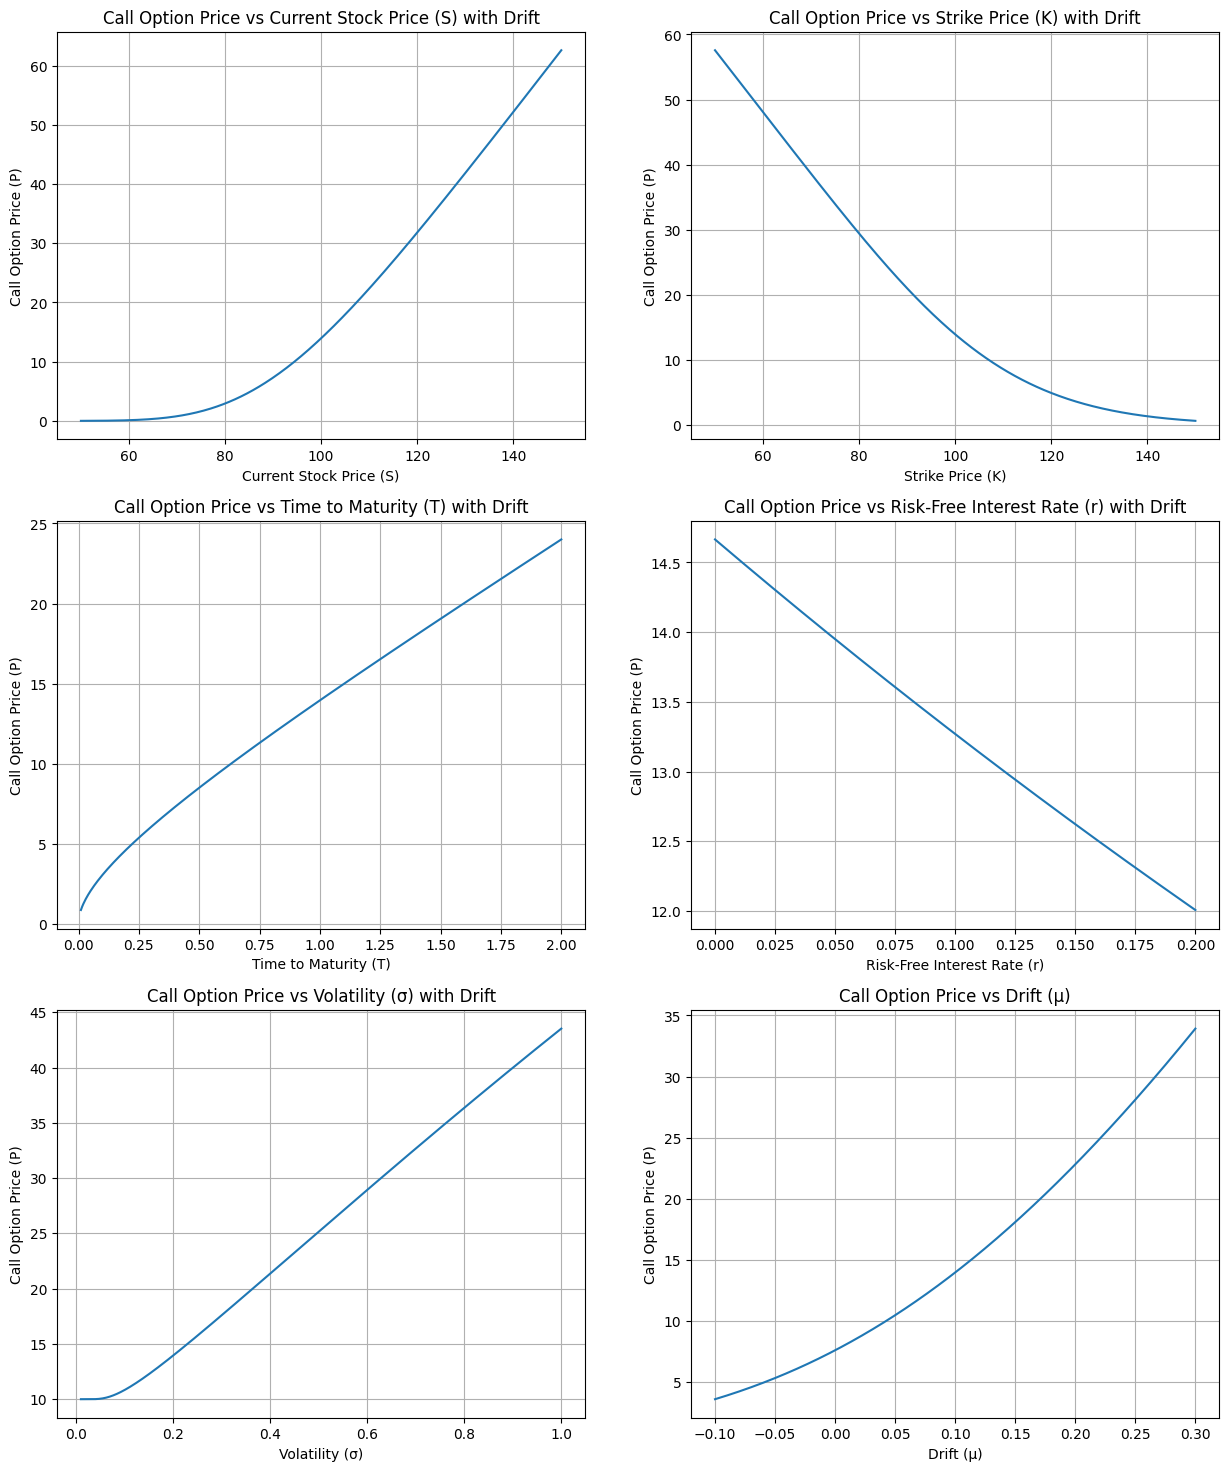

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula with drift implementation
def black_scholes_with_drift(S, K, T, t, r, mu, sigma):
    d1_mu = (np.log(S / K) + (mu + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2_mu = d1_mu - sigma * np.sqrt(T - t)
    call_price_with_drift = S * np.exp((mu - r) * (T - t)) * norm.cdf(d1_mu) - K * np.exp(-r * (T - t)) * norm.cdf(d2_mu)
    return call_price_with_drift

# Parameters for the plots
S_t = 100   # Current stock price
K = 100     # Strike price
T = 1       # Time to maturity (1 year)
t = 0       # Current time (now)
r = 0.05    # Risk-free interest rate (5%)
mu = 0.1    # Drift rate (10%)
sigma = 0.2 # Volatility (20%)

# Generate data for each dependency plot
S_values = np.linspace(50, 150, 400)
K_values = np.linspace(50, 150, 400)
T_values = np.linspace(0.01, 2, 400)
r_values = np.linspace(0, 0.2, 400)
sigma_values = np.linspace(0.01, 1, 400)
mu_values = np.linspace(-0.1, 0.3, 400)

# Calculate call prices with drift
C_S_drift = [black_scholes_with_drift(S, K, T, t, r, mu, sigma) for S in S_values]
C_K_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for K in K_values]
C_T_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for T in T_values]
C_r_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for r in r_values]
C_sigma_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for sigma in sigma_values]
C_mu_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for mu in mu_values]

# Plotting all dependencies in a single figure for export

fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Current Stock Price (S) with Drift
axs[0, 0].plot(S_values, C_S_drift)
axs[0, 0].set_title('Call Option Price vs Current Stock Price (S) with Drift')
axs[0, 0].set_xlabel('Current Stock Price (S)')
axs[0, 0].set_ylabel('Call Option Price (P)')
axs[0, 0].grid(True)

# Strike Price (K) with Drift
axs[0, 1].plot(K_values, C_K_drift)
axs[0, 1].set_title('Call Option Price vs Strike Price (K) with Drift')
axs[0, 1].set_xlabel('Strike Price (K)')
axs[0, 1].set_ylabel('Call Option Price (P)')
axs[0, 1].grid(True)

# Time to Maturity (T) with Drift
axs[1, 0].plot(T_values, C_T_drift)
axs[1, 0].set_title('Call Option Price vs Time to Maturity (T) with Drift')
axs[1, 0].set_xlabel('Time to Maturity (T)')
axs[1, 0].set_ylabel('Call Option Price (P)')
axs[1, 0].grid(True)

# Risk-Free Interest Rate (r) with Drift
axs[1, 1].plot(r_values, C_r_drift)
axs[1, 1].set_title('Call Option Price vs Risk-Free Interest Rate (r) with Drift')
axs[1, 1].set_xlabel('Risk-Free Interest Rate (r)')
axs[1, 1].set_ylabel('Call Option Price (P)')
axs[1, 1].grid(True)

# Volatility (σ) with Drift
axs[2, 0].plot(sigma_values, C_sigma_drift)
axs[2, 0].set_title('Call Option Price vs Volatility (σ) with Drift')
axs[2, 0].set_xlabel('Volatility (σ)')
axs[2, 0].set_ylabel('Call Option Price (P)')
axs[2, 0].grid(True)

# Drift (μ)
axs[2, 1].plot(mu_values, C_mu_drift)
axs[2, 1].set_title('Call Option Price vs Drift (μ)')
axs[2, 1].set_xlabel('Drift (μ)')
axs[2, 1].set_ylabel('Call Option Price (P)')
axs[2, 1].grid(True)

## The arbitrage-free theory of derivatives pricing


### Call option premium using arbitrage-free theory

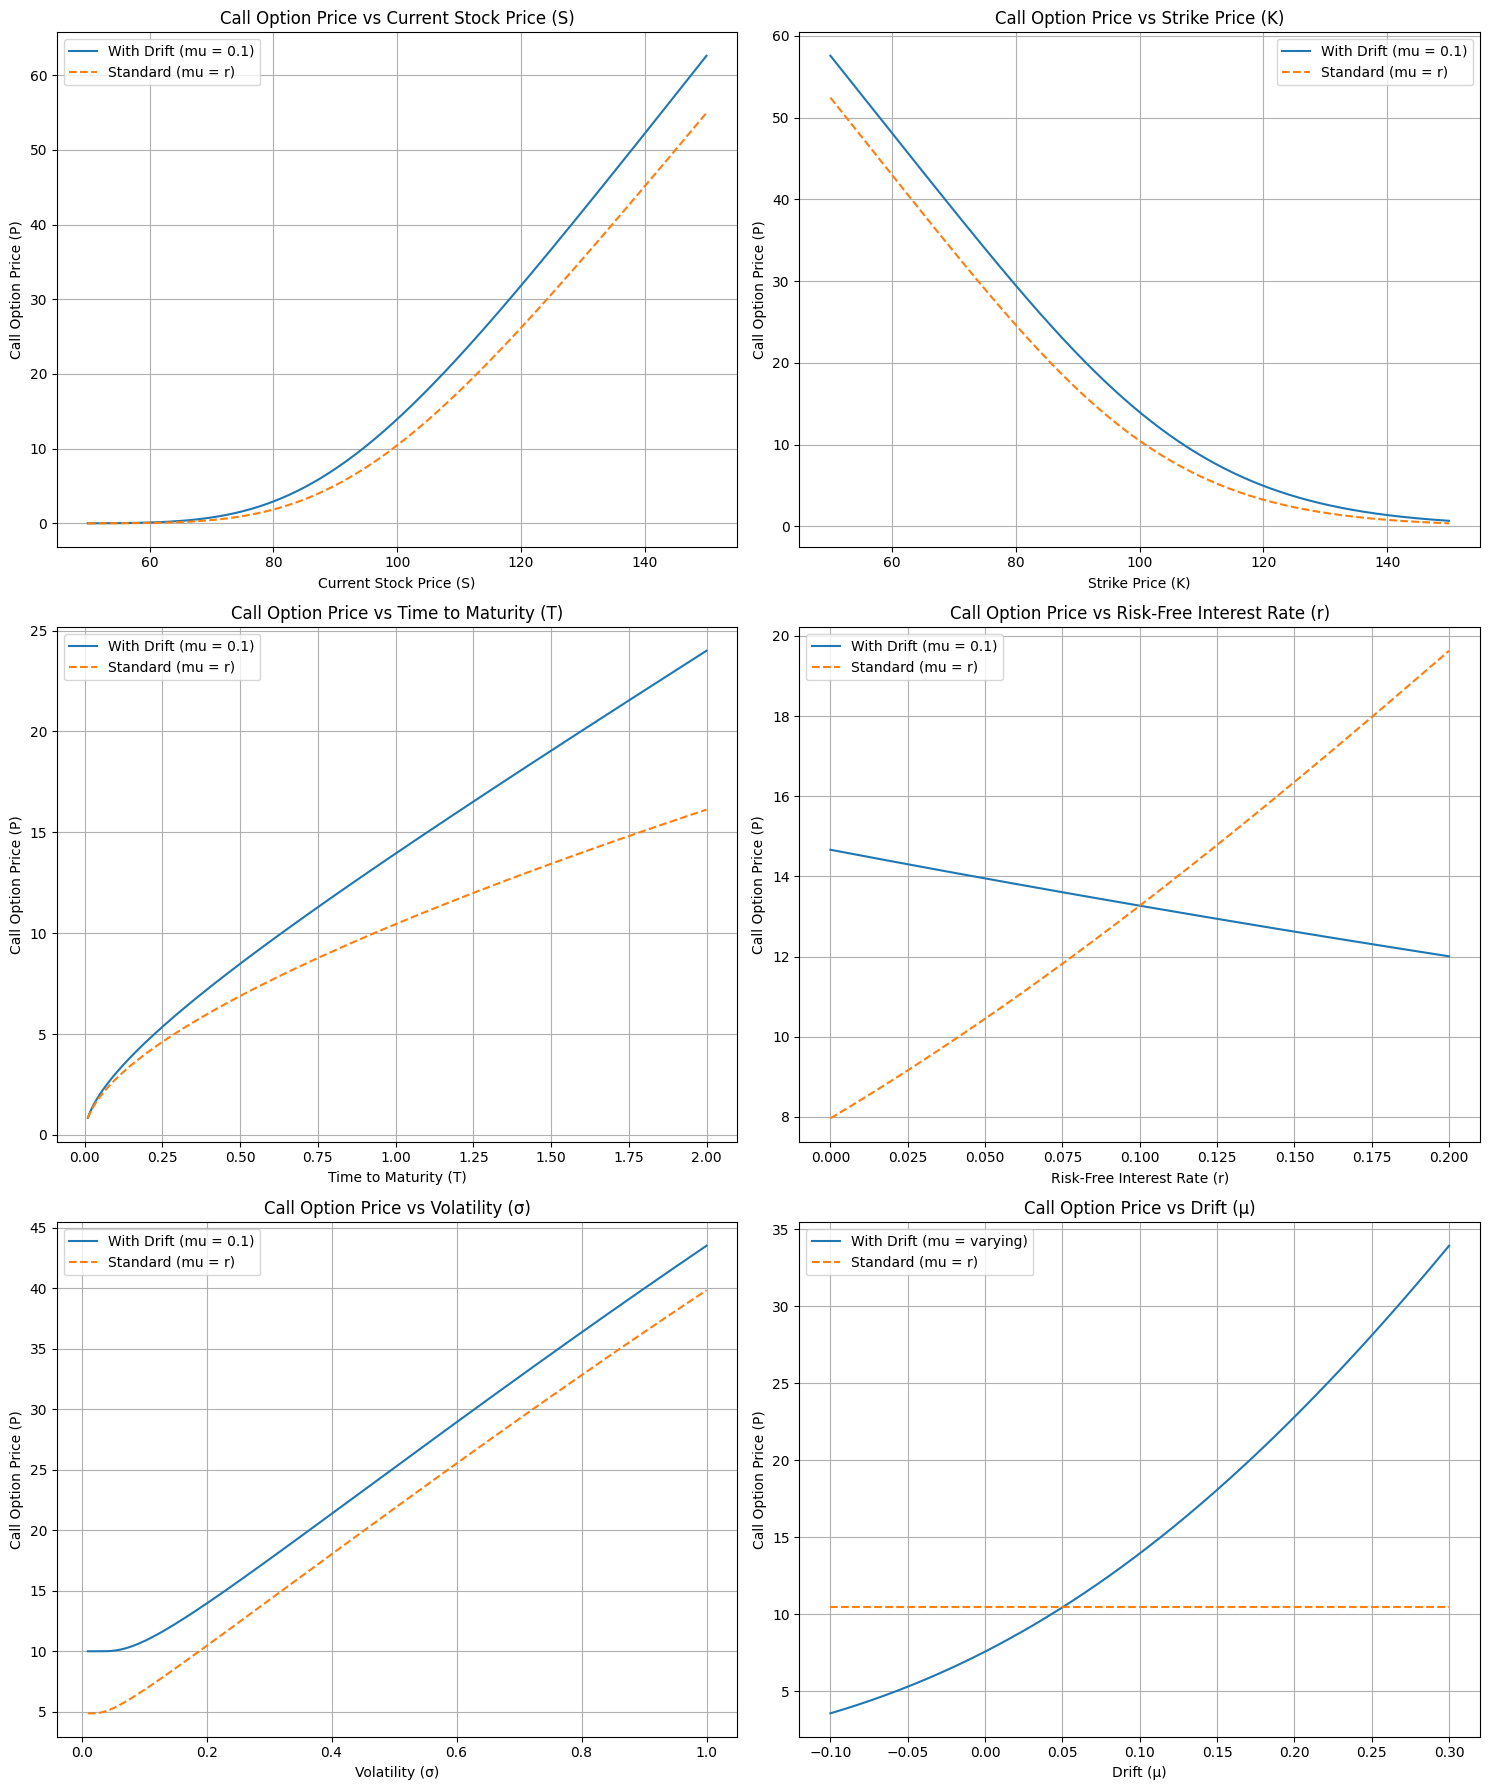

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula with drift implementation
def black_scholes_with_drift(S, K, T, t, r, mu, sigma):
    d1_mu = (np.log(S / K) + (mu + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2_mu = d1_mu - sigma * np.sqrt(T - t)
    call_price_with_drift = S * np.exp((mu - r) * (T - t)) * norm.cdf(d1_mu) - K * np.exp(-r * (T - t)) * norm.cdf(d2_mu)
    return call_price_with_drift

# Standard Black-Scholes formula (mu = r)
def black_scholes_standard(S, K, T, t, r, sigma):
    return black_scholes_with_drift(S, K, T, t, r, r, sigma)

# Parameters for the plots
S_t = 100   # Current stock price
K = 100     # Strike price
T = 1       # Time to maturity (1 year)
t = 0       # Current time (now)
r = 0.05    # Risk-free interest rate (5%)
mu = 0.1    # Drift rate (10%)
sigma = 0.2 # Volatility (20%)

# Generate data for each dependency plot
S_values = np.linspace(50, 150, 400)
K_values = np.linspace(50, 150, 400)
T_values = np.linspace(0.01, 2, 400)
r_values = np.linspace(0, 0.2, 400)
sigma_values = np.linspace(0.01, 1, 400)
mu_values = np.linspace(-0.1, 0.3, 400)

# Calculate call prices with drift
C_S_drift = [black_scholes_with_drift(S, K, T, t, r, mu, sigma) for S in S_values]
C_K_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for K in K_values]
C_T_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for T in T_values]
C_r_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for r in r_values]
C_sigma_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for sigma in sigma_values]
C_mu_drift = [black_scholes_with_drift(S_t, K, T, t, r, mu, sigma) for mu in mu_values]

# Calculate call prices using standard Black-Scholes formula (mu = r)
C_S_standard = [black_scholes_standard(S, K, T, t, r, sigma) for S in S_values]
C_K_standard = [black_scholes_standard(S_t, K, T, t, r, sigma) for K in K_values]
C_T_standard = [black_scholes_standard(S_t, K, T, t, r, sigma) for T in T_values]
C_r_standard = [black_scholes_standard(S_t, K, T, t, r, sigma) for r in r_values]
C_sigma_standard = [black_scholes_standard(S_t, K, T, t, r, sigma) for sigma in sigma_values]
C_mu_standard = [black_scholes_standard(S_t, K, T, t, r, sigma) for mu in mu_values]

# Plotting all dependencies in a single figure for comparison
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Current Stock Price (S) comparison
axs[0, 0].plot(S_values, C_S_drift, label="With Drift (mu = 0.1)")
axs[0, 0].plot(S_values, C_S_standard, label="Standard (mu = r)", linestyle="--")
axs[0, 0].set_title('Call Option Price vs Current Stock Price (S)')
axs[0, 0].set_xlabel('Current Stock Price (S)')
axs[0, 0].set_ylabel('Call Option Price (P)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Strike Price (K) comparison
axs[0, 1].plot(K_values, C_K_drift, label="With Drift (mu = 0.1)")
axs[0, 1].plot(K_values, C_K_standard, label="Standard (mu = r)", linestyle="--")
axs[0, 1].set_title('Call Option Price vs Strike Price (K)')
axs[0, 1].set_xlabel('Strike Price (K)')
axs[0, 1].set_ylabel('Call Option Price (P)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Time to Maturity (T) comparison
axs[1, 0].plot(T_values, C_T_drift, label="With Drift (mu = 0.1)")
axs[1, 0].plot(T_values, C_T_standard, label="Standard (mu = r)", linestyle="--")
axs[1, 0].set_title('Call Option Price vs Time to Maturity (T)')
axs[1, 0].set_xlabel('Time to Maturity (T)')
axs[1, 0].set_ylabel('Call Option Price (P)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Risk-Free Interest Rate (r) comparison
axs[1, 1].plot(r_values, C_r_drift, label="With Drift (mu = 0.1)")
axs[1, 1].plot(r_values, C_r_standard, label="Standard (mu = r)", linestyle="--")
axs[1, 1].set_title('Call Option Price vs Risk-Free Interest Rate (r)')
axs[1, 1].set_xlabel('Risk-Free Interest Rate (r)')
axs[1, 1].set_ylabel('Call Option Price (P)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Volatility (σ) comparison
axs[2, 0].plot(sigma_values, C_sigma_drift, label="With Drift (mu = 0.1)")
axs[2, 0].plot(sigma_values, C_sigma_standard, label="Standard (mu = r)", linestyle="--")
axs[2, 0].set_title('Call Option Price vs Volatility (σ)')
axs[2, 0].set_xlabel('Volatility (σ)')
axs[2, 0].set_ylabel('Call Option Price (P)')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Drift (μ) comparison
axs[2, 1].plot(mu_values, C_mu_drift, label="With Drift (mu = varying)")
axs[2, 1].plot(mu_values, C_mu_standard, label="Standard (mu = r)", linestyle="--")
axs[2, 1].set_title('Call Option Price vs Drift (μ)')
axs[2, 1].set_xlabel('Drift (μ)')
axs[2, 1].set_ylabel('Call Option Price (P)')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


### Using the BSM framework in practice

Simulating Perfect Setup with Rehedging Frequency: Every 1 steps
Simulating Perfect Setup with Rehedging Frequency: Every 10 steps
Simulating Perfect Setup with Rehedging Frequency: Every 100 steps
Simulating Different Volatility in Simulation: sigma_sim = 0.19
Simulating Different Volatility in Simulation: sigma_sim = 0.21
Simulating Stochastic Volatility (Heston Model)
Simulating With Transaction Costs (Half Spread = 0.005%)


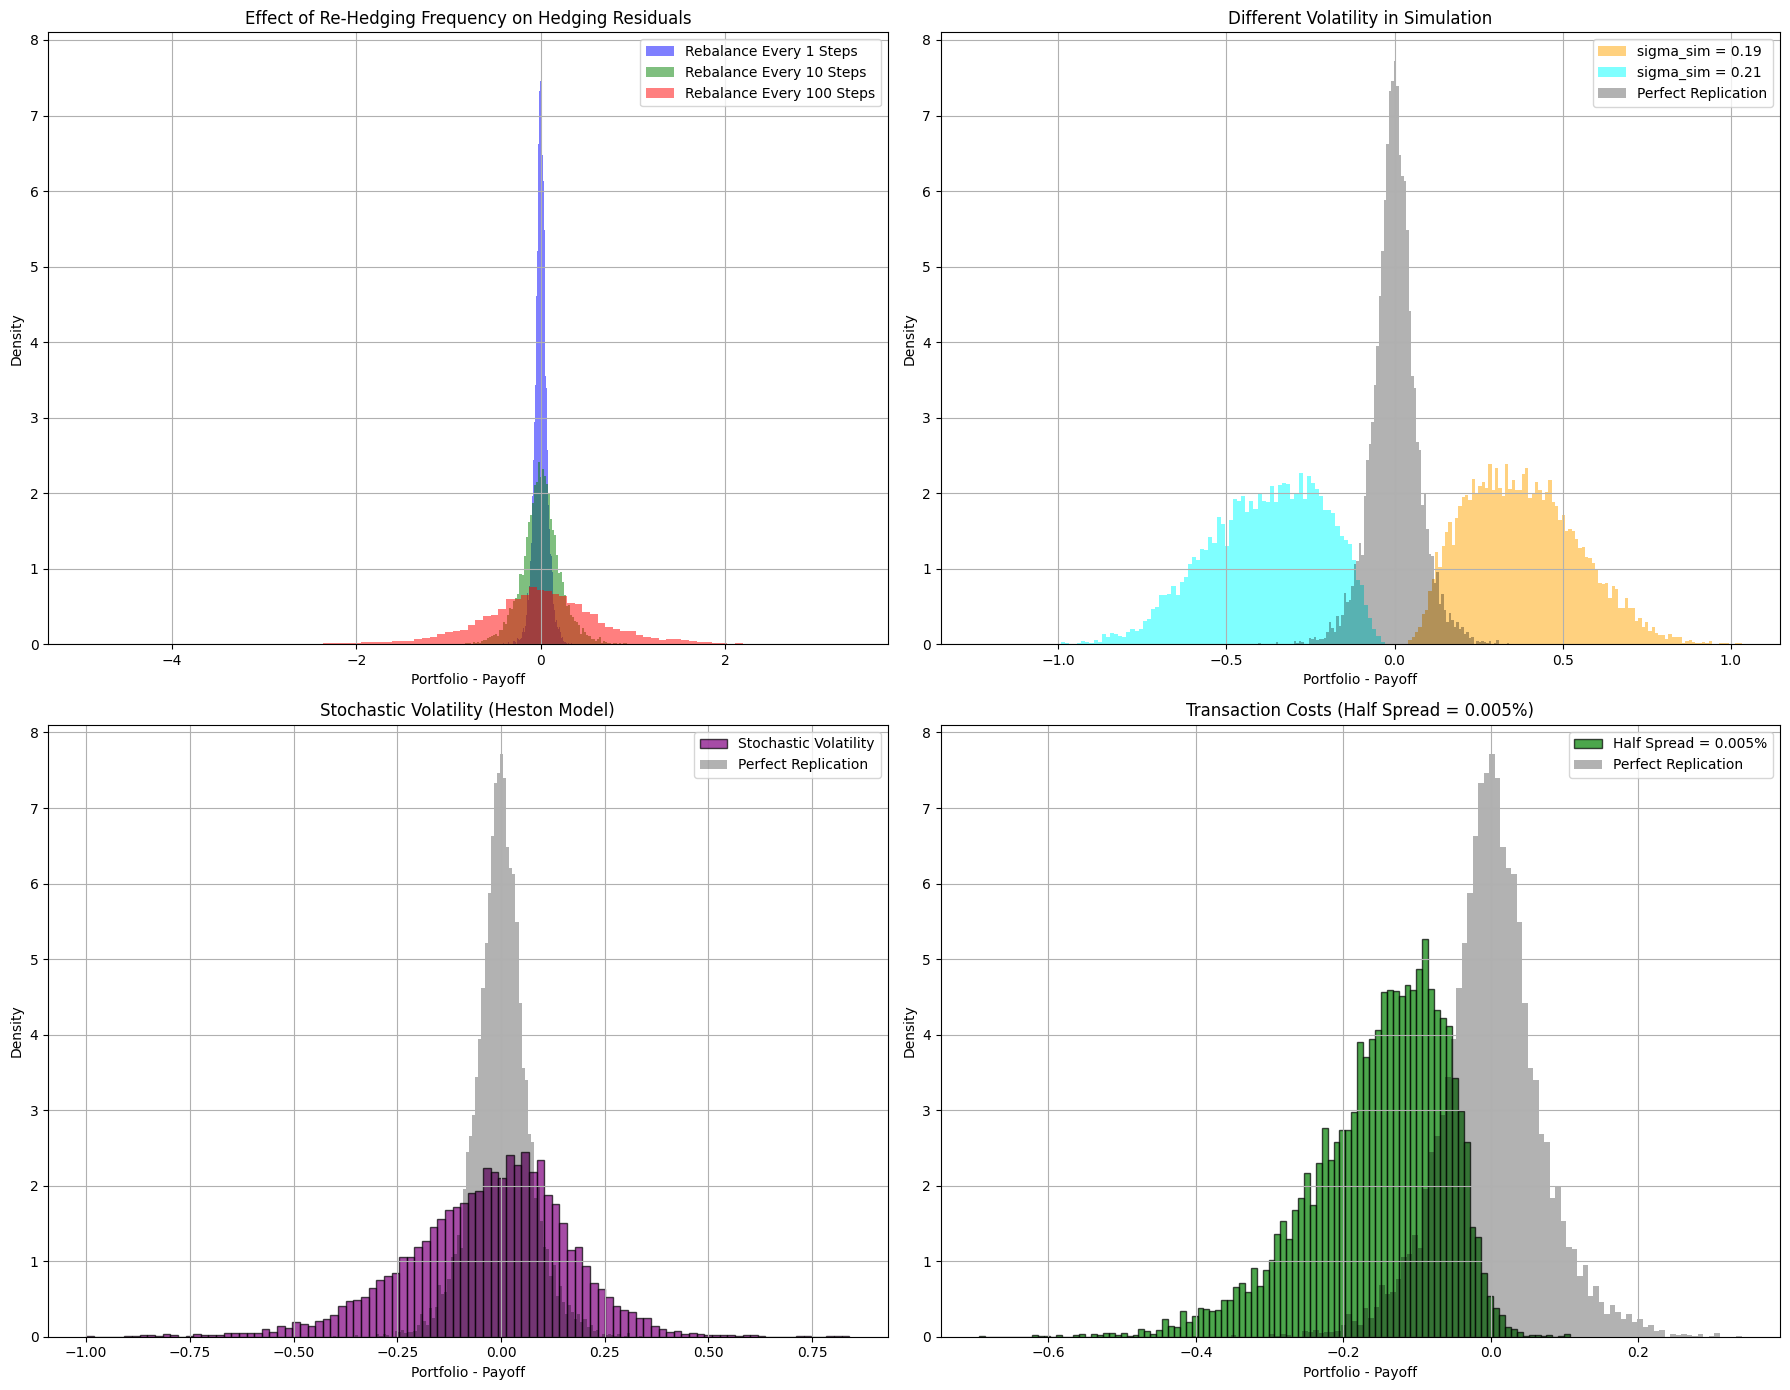

Summary Statistics for Perfect Setup with Varied Re-Hedging Frequency:
Rebalance Every 1 Steps: Mean = 0.000827, Std Dev = 0.068216
Rebalance Every 10 Steps: Mean = 0.003540, Std Dev = 0.214217
Rebalance Every 100 Steps: Mean = -0.011300, Std Dev = 0.690467
------------------------------------------------------------
Summary Statistics for Violations:
Different Volatility in Simulation (sigma_sim = 0.19):
  Mean difference: 0.381420
  Std Dev of difference: 0.164161
Different Volatility in Simulation (sigma_sim = 0.21):
  Mean difference: -0.381580
  Std Dev of difference: 0.172823
Stochastic Volatility (Heston Model):
  Mean difference: -0.032125
  Std Dev of difference: 0.193527
Transaction Costs (Half Spread = 0.005%):
  Mean difference: -0.152493
  Std Dev of difference: 0.092860
----------------------------------------


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma **2 ) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price

def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option delta.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma **2 ) * T ) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return delta

def simulate_gbm_paths(S0, mu, sigma, T, dt, n_paths, 
                      stochastic_vol=False, kappa=2.0, theta=0.04, xi=0.2, rho=-0.7):
    """
    Simulate GBM paths with optional stochastic volatility based on the Heston model.
    
    Parameters:
    - S0: initial stock price
    - mu: drift
    - sigma: initial volatility
    - T: maturity
    - dt: time step
    - n_paths: number of simulation paths
    - stochastic_vol: if True, use the Heston stochastic volatility model
    - kappa: rate of mean reversion of variance (only if stochastic_vol=True)
    - theta: long-term variance mean (only if stochastic_vol=True)
    - xi: volatility of variance (only if stochastic_vol=True)
    - rho: correlation between stock and variance (only if stochastic_vol=True)
    
    Returns:
    - paths: array of shape (n_steps +1, n_paths)
    """
    n_steps = int(T / dt)
    paths = np.zeros((n_steps +1, n_paths))
    paths[0] = S0
    
    if stochastic_vol:
        # Initialize variance
        V0 = sigma ** 2
        variances = np.zeros((n_steps +1, n_paths))
        variances[0] = V0
        
        # Precompute correlation matrix and Cholesky decomposition
        cov_matrix = np.array([[1.0, rho],
                               [rho, 1.0]])
        L = np.linalg.cholesky(cov_matrix)
        
        for t in range(1, n_steps +1):
            # Simulate two correlated random variables
            Z = np.random.standard_normal((2, n_paths))
            correlated_Z = L @ Z
            Z_S = correlated_Z[0]
            Z_V = correlated_Z[1]
            
            # Update variance using CIR process
            V_prev = variances[t-1]
            V = V_prev + kappa * (theta - V_prev) * dt + xi * np.sqrt(np.maximum(V_prev, 0)) * np.sqrt(dt) * Z_V
            V = np.maximum(V, 0)  # Ensure variance is non-negative
            variances[t] = V
            
            # Update stock price
            S_prev = paths[t-1]
            S = S_prev * np.exp( (mu - 0.5 * V_prev) * dt + np.sqrt(V_prev) * np.sqrt(dt) * Z_S )
            paths[t] = S
    else:
        for t in range(1, n_steps +1):
            Z = np.random.standard_normal(n_paths)
            paths[t] = paths[t-1] * np.exp( (mu - 0.5 * sigma **2 ) * dt + sigma * np.sqrt(dt) * Z )
    
    return paths

def dynamic_hedging(paths, S0, K, T, r, sigma_bs, option_type='call', dt=1/252,
                   rehedge_freq=1, half_spread=0.0, sigma_sim=None):
    """
    Implement dynamic hedging strategy.
    
    Parameters:
    - paths: simulated stock price paths (array of shape (n_steps+1, n_paths))
    - S0: initial stock price
    - K: strike price
    - T: maturity
    - r: risk-free rate
    - sigma_bs: volatility used in BS model
    - option_type: 'call' or 'put'
    - dt: time step size
    - rehedge_freq: frequency of rehedging in terms of number of steps. If 1, rebalance every step.
    - half_spread: transaction cost as a fraction of price (half spread for buying and selling)
    - sigma_sim: volatility used in simulation (if different from sigma_bs)
    
    Returns:
    - differences: array of portfolio - payoff for each path
    """
    n_steps, n_paths = paths.shape[0]-1, paths.shape[1]
    # Calculate option price and initial delta
    option_price = black_scholes_price(S0, K, T, r, sigma_bs, option_type)
    option_delta = black_scholes_delta(S0, K, T, r, sigma_bs, option_type)
    
    # Initialize portfolio
    portfolio = np.full(n_paths, option_price)
    stock_position = np.full(n_paths, option_delta)
    cash_position = portfolio - stock_position * S0
    
    # Time steps
    times = np.linspace(0, T, n_steps +1)
    
    # Rehedge steps
    rehedge_steps = rehedge_freq
    
    for t in range(1, n_steps +1):
        tau = T - times[t]
        if tau <= 0:
            tau = 1e-10  # Avoid division by zero
        
        # Determine if rebalancing is needed
        if t % rehedge_steps == 0:
            # Compute delta using BS formula
            current_S = paths[t]
            current_delta = black_scholes_delta(current_S, K, tau, r, sigma_bs, option_type)
            
            # Calculate change in delta
            delta_change = current_delta - stock_position
            # Calculate transaction cost
            transaction_cost = half_spread * np.abs(delta_change * current_S)
            
            # Update cash position
            cash_position = cash_position * np.exp(r * dt) - delta_change * current_S - transaction_cost
            
            # Update stock position
            stock_position = current_delta
        else:
            # Just grow the cash position
            cash_position = cash_position * np.exp(r * dt)
        
        # Update portfolio value
        portfolio = cash_position + stock_position * paths[t]
    
    # Option payoff
    if option_type == 'call':
        payoff = np.maximum(paths[-1] - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - paths[-1], 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    differences = portfolio - payoff
    return differences

def run_simulation():
    # Parameters
    S0 = 100          # Initial stock price
    K = 100           # Strike price
    T = 1.0           # 1 year
    r = 0.05          # 5% risk-free rate
    sigma_bs = 0.20   # 20% volatility used in Black-Scholes model
    mu = 0.1          # 10% drift
    option_type = 'call'
    n_paths = 10000   # Number of simulation paths
    dt = 1/10000      # Fixed small time step for accurate approximation
    
    # Perfect setup with varying rehedging frequency
    rehedge_freq_values = [1, 10, 100]  # Rebalance every 1, 10, 100 steps
    differences_rehedge_freq = {}
    
    # Simulate perfect hedging with varying rehedging frequencies
    for freq in rehedge_freq_values:
        print(f"Simulating Perfect Setup with Rehedging Frequency: Every {freq} steps")
        paths_perfect = simulate_gbm_paths(S0, mu, sigma_bs, T, dt, n_paths, stochastic_vol=False)
        differences = dynamic_hedging(paths_perfect, S0, K, T, r, sigma_bs, option_type, dt, 
                                     rehedge_freq=freq, half_spread=0.0)
        differences_rehedge_freq[freq] = differences
    
    # Baseline residuals (Rebalance every step)
    residuals_perfect = differences_rehedge_freq[1]
    
    # Violations
    # 1. Different volatility for simulation (sigma_sim = 0.19 and 0.21)
    sigma_sim_values = [0.19, 0.21]
    differences_sigma_sim = {}
    for sigma_sim in sigma_sim_values:
        print(f"Simulating Different Volatility in Simulation: sigma_sim = {sigma_sim}")
        paths_diff_vol = simulate_gbm_paths(S0, mu, sigma_sim, T, dt, n_paths, stochastic_vol=False)
        differences = dynamic_hedging(paths_diff_vol, S0, K, T, r, sigma_bs, option_type, dt, 
                                     rehedge_freq=1, half_spread=0.0)
        differences_sigma_sim[sigma_sim] = differences
    
    # 2. Stochastic Volatility (Heston Model)
    print("Simulating Stochastic Volatility (Heston Model)")
    paths_stoch_vol = simulate_gbm_paths(S0, mu, sigma_bs, T, dt, n_paths, stochastic_vol=True,
                                        kappa=20.0, theta=0.04, xi=0.2, rho=-0.7)
    differences_stoch_vol = dynamic_hedging(paths_stoch_vol, S0, K, T, r, sigma_bs, option_type, dt, 
                                           rehedge_freq=1, half_spread=0.0)
    
    # 3. Transaction Costs (Half Spread = 0.005%)
    half_spread = 0.00005  # 0.005%
    print("Simulating With Transaction Costs (Half Spread = 0.005%)")
    paths_half_spread = simulate_gbm_paths(S0, mu, sigma_bs, T, dt, n_paths, stochastic_vol=False)
    differences_half_spread = dynamic_hedging(paths_half_spread, S0, K, T, r, sigma_bs, option_type, dt, 
                                             rehedge_freq=1, half_spread=half_spread)
    
    # Plot histograms in a 2x2 grid
    plt.figure(figsize=(18, 14))
    
    # Subplot 1: Effect of Re-Hedging Frequency on Hedging Residuals
    plt.subplot(2, 2, 1)
    colors = ['blue', 'green', 'red', 'purple']
    labels = [f'Rebalance Every {freq} Steps' for freq in rehedge_freq_values]
    
    for i, freq in enumerate(rehedge_freq_values):
        plt.hist(differences_rehedge_freq[freq], bins=100, alpha=0.5, 
                 color=colors[i], label=labels[i], density=True)
    
    plt.title('Effect of Re-Hedging Frequency on Hedging Residuals')
    plt.xlabel('Portfolio - Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Different Volatility in Simulation
    plt.subplot(2, 2, 2)
    colors_sigma = ['orange', 'cyan']
    labels_sigma = [f'sigma_sim = {sigma_sim:.2f}' for sigma_sim in sigma_sim_values]
    
    for i, sigma_sim in enumerate(sigma_sim_values):
        plt.hist(differences_sigma_sim[sigma_sim], bins=100, alpha=0.5, 
                 color=colors_sigma[i], label=labels_sigma[i], density=True)
    
    # Add baseline
    plt.hist(residuals_perfect, bins=100, alpha=0.3, color='black', label='Perfect Replication', density=True)
    
    plt.title('Different Volatility in Simulation')
    plt.xlabel('Portfolio - Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Stochastic Volatility (Heston Model)
    plt.subplot(2, 2, 3)
    plt.hist(differences_stoch_vol, bins=100, alpha=0.7, color='purple', edgecolor='black', density=True, label='Stochastic Volatility')
    
    # Add baseline
    plt.hist(residuals_perfect, bins=100, alpha=0.3, color='black', label='Perfect Replication', density=True)
    
    plt.title('Stochastic Volatility (Heston Model)')
    plt.xlabel('Portfolio - Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    # Subplot 4: Transaction Costs (Half Spread)
    plt.subplot(2, 2, 4)
    plt.hist(differences_half_spread, bins=100, alpha=0.7, color='green', edgecolor='black', density=True, label='Half Spread = 0.005%')
    
    # Add baseline
    plt.hist(residuals_perfect, bins=100, alpha=0.3, color='black', label='Perfect Replication', density=True)
    
    plt.title('Transaction Costs (Half Spread = 0.005%)')
    plt.xlabel('Portfolio - Payoff')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics for Perfect Setup with varied rehedging frequency
    print("Summary Statistics for Perfect Setup with Varied Re-Hedging Frequency:")
    for freq, diff in differences_rehedge_freq.items():
        print(f"Rebalance Every {freq} Steps: Mean = {np.mean(diff):.6f}, Std Dev = {np.std(diff):.6f}")
    print("-"*60)
    
    # Summary statistics for Violations
    print("Summary Statistics for Violations:")
    
    # 1. Different Volatility in Simulation
    for sigma_sim, diff in differences_sigma_sim.items():
        print(f"Different Volatility in Simulation (sigma_sim = {sigma_sim:.2f}):")
        print(f"  Mean difference: {np.mean(diff):.6f}")
        print(f"  Std Dev of difference: {np.std(diff):.6f}")
    
    # 2. Stochastic Volatility (Heston Model)
    print("Stochastic Volatility (Heston Model):")
    print(f"  Mean difference: {np.mean(differences_stoch_vol):.6f}")
    print(f"  Std Dev of difference: {np.std(differences_stoch_vol):.6f}")
    
    # 3. Transaction Costs (Half Spread)
    print("Transaction Costs (Half Spread = 0.005%):")
    print(f"  Mean difference: {np.mean(differences_half_spread):.6f}")
    print(f"  Std Dev of difference: {np.std(differences_half_spread):.6f}")
    print("-"*40)

if __name__ == "__main__":
    run_simulation()
